In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np

# Load data

In [2]:
df_field = pd.read_csv("studies/batch_run_field.csv")
df_field["beta"] = df_field["beta"].apply(lambda x: np.round(x,2))

df_field["magnetization"] = df_field["magnetization"]/(30*30) # magnetization per atom
df_field["magnetization_abs"] = np.abs(df_field["magnetization"])

# select the variables relative to the study
df_field = df_field[["RunId","iteration","Step", "beta","magnetic_field","energy", "magnetization", "magnetization_abs"]]

# calculate averages per parameter combo
df_field = df_field.groupby(["beta", "magnetic_field", "Step"]).mean().reset_index()

df_field.head(2)

,beta,magnetic_field,Step,RunId,iteration,energy,magnetization,magnetization_abs
0,0.1,-1,0,1336.5,49.5,-0.366022,0.318956,0.318956
1,0.1,-1,1,1336.5,49.5,-0.402267,0.222889,0.222889


In [3]:
df_voter = pd.read_csv("studies/batch_run_voting.csv")
# df.head(2)

df_voter["magnetization"] = df_voter["magnetization"]/(30*30) # magnetization per atom
df_voter["magnetization_abs"] = np.abs(df_voter["magnetization"])

# select the variables relative to the study
df_voter = df_voter[["RunId","iteration","Step", "prob","algo", "energy", "magnetization", "magnetization_abs"]]

# calculate averages per parameter combo
df_voter = df_voter.groupby(["prob", "algo", "Step"]).mean().reset_index()

df_voter.head(2)

,prob,algo,Step,RunId,iteration,energy,magnetization,magnetization_abs
0,0.1,majority,0,891.0,49.5,-2.219467,-0.613489,0.613489
1,0.1,majority,1,891.0,49.5,-2.468711,-0.755778,0.755778


# Visualizations

## Color setup

In [4]:
# betas in the study - use inverse coolwarm colormap
betas = sorted(set(df_field.beta.value_counts().index))
normalize_betas = plt.Normalize(min(betas), max(betas))
colormap_betas = plt.cm.coolwarm.reversed()
colors_betas = colormap_betas(normalize_betas(betas))

# color scale
sm_betas = cm.ScalarMappable(cmap=colormap_betas, norm=normalize_betas)
sm_betas.set_array([])

# probs in the study - use coolwarm colormap
probs = sorted(set(df_voter.prob.value_counts().index))
normalize_probs = plt.Normalize(min(probs), max(probs))
colormap_probs = plt.cm.coolwarm
colors_probs = colormap_probs(normalize_probs(probs))

# color scale
sm_probs = cm.ScalarMappable(cmap=colormap_probs, norm=normalize_probs)
sm_probs.set_array([])

## Compare Ising vs Voter

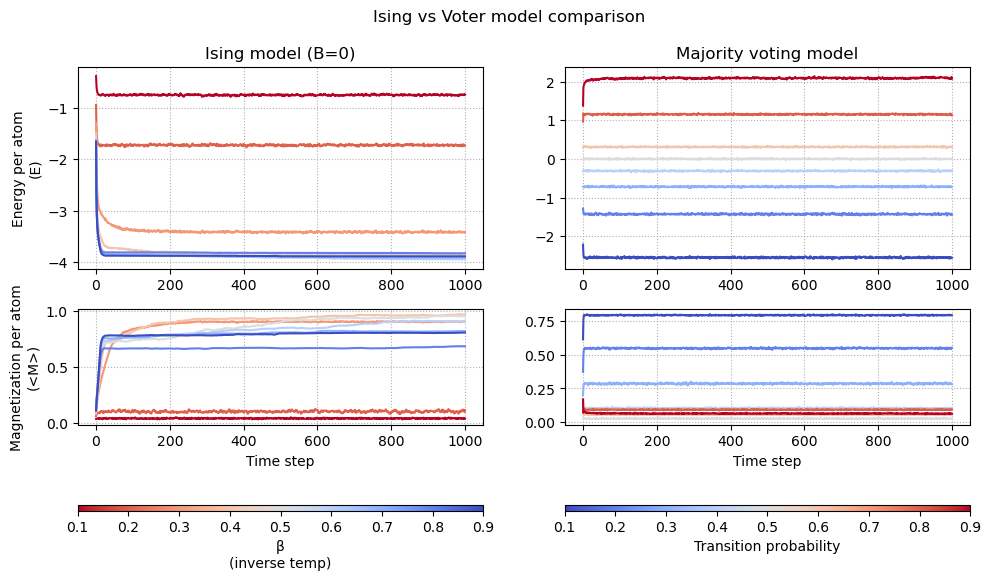

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(1.8*6.4, 1.2*4.8))

for beta, color_beta, color_prob in zip(betas, colors_betas, colors_probs): # one line per temperature
    sm_betas.to_rgba(beta)

    df_plot = df_field[df_field["beta"] == beta] 

    # sort accroding to simulation step (time)
    df_plot_0 = df_plot[df_plot["magnetic_field"] == 0]
    df_plot_0 = df_plot_0.sort_values(by="Step", ascending=True)

    axs[0][0].plot(df_plot_0["Step"], df_plot_0["energy"], label=f'{beta:.2f}', color=color_beta)
    axs[1][0].plot(df_plot_0["Step"], df_plot_0["magnetization_abs"], label=f'{beta:.2f}', color=color_beta)


    df_plot_voter = df_voter[df_voter["prob"] == beta] 

    df_maj = df_plot_voter[df_plot_voter["algo"] == "majority"]
    df_maj.sort_values(by="Step", ascending=True)

    axs[0][1].plot(df_maj["Step"], df_maj["energy"], label=f'{beta:.2f}', color=color_prob)
    axs[1][1].plot(df_maj["Step"], df_maj["magnetization_abs"], label=f'{beta:.2f}', color=color_prob)

# dividers for colorbars
divider = make_axes_locatable(axs[1][0])
cax = divider.append_axes("bottom", size="5%", pad=0.8)
fig.colorbar(sm_betas, cax=cax, orientation='horizontal',label='β\n(inverse temp)')

divider = make_axes_locatable(axs[1][1])
cax = divider.append_axes("bottom", size="5%", pad=0.8)
fig.colorbar(sm_probs, cax=cax, orientation='horizontal',label='Transition probability')

# add grid lines
for ax in axs.flatten(): ax.grid(ls=":")

# set titles and labels
fig.suptitle("Ising vs Voter model comparison")
axs[0][0].set_title("Ising model (B=0)")
axs[0][1].set_title("Majority voting model")

for ax in axs[1]: ax.set_xlabel("Time step")

axs[0][0].set_ylabel("Energy per atom\n(E)")
axs[1][0].set_ylabel("Magnetization per atom\n(<M>)");

fig.savefig("plots/model_comparison.png", dpi=300)

## Ising for positive field

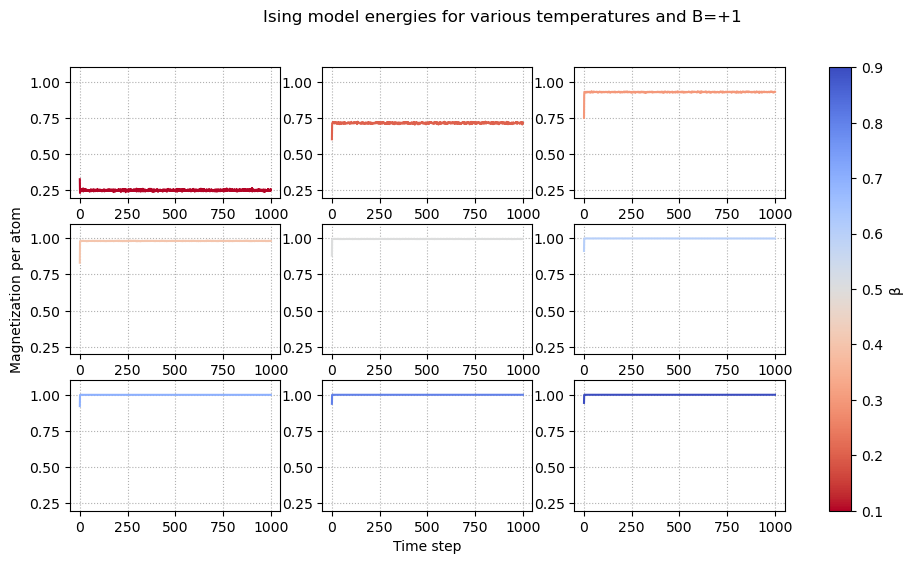

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(1.8*6.4, 1.2*4.8))

for beta, color, ax in zip(betas[:], colors_betas[:], axs.flatten()):
    df_plot_1 = df_field[df_field["magnetic_field"] == 1]
    df_plot_1 = df_plot_1[df_plot_1["beta"] == np.round(beta,2)]
    df_plot_1.sort_values(by="Step", ascending=True)

    ax.plot(df_plot_1.Step, df_plot_1.magnetization_abs, color=color)

# add colorbar
fig.colorbar(sm_betas, ax=axs.ravel().tolist(), orientation='vertical', label='β')

# titles, labels and axes limits
fig.suptitle("Ising model energies for various temperatures and B=+1")
axs[1][0].set_ylabel("Magnetization per atom")
axs[2][1].set_xlabel("Time step")
for ax in axs.flatten():
    ax.set_ylim(0.2, 1.1)
    ax.grid(ls=":")

fig.savefig("plots/positive_field.png", dpi=300)